<a href="https://colab.research.google.com/github/gizemerpek/Turkish-hate-speech-detection/blob/main/hate_speech_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y openjdk-11-jdk-headless

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.25+9-1ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!pip install jpype1

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from snowballstemmer import TurkishStemmer
from jpype import startJVM, shutdownJVM, JClass, JString, isJVMStarted
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from lightgbm import early_stopping as lgb_early_stopping
from xgboost import XGBClassifier, DMatrix


# Zemberek'i başlat
if not isJVMStarted():
    startJVM("-ea", f"-Djava.class.path=zemberek-full.jar")
TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
TurkishSpellChecker = JClass('zemberek.normalization.TurkishSpellChecker')
morphology = TurkishMorphology.createWithDefaults()
spell_checker = TurkishSpellChecker(morphology)

# Veriyi yükle
file_path = '/content/Türkçe Nefret Söylemi Veriseti.xlsx'
xlsx = pd.ExcelFile(file_path)
sheet_names = xlsx.sheet_names
sheets_to_merge = [sheet for sheet in sheet_names if sheet != "TOPLAM" and sheet != sheet_names[0]]
merged_data = pd.concat([xlsx.parse(sheet, header=1) for sheet in sheets_to_merge], ignore_index=True)

# Küçük harfe çevirme ve noktalama işaretlerini kaldırma
merged_data['Tweet'] = merged_data['Tweet'].str.lower()
merged_data['Tweet'] = merged_data['Tweet'].str.replace(r'[^\w\s]', '', regex=True)

# spelling correction with Zemberek
def correct_spelling(text):
    words = text.split()
    corrected_words = []
    for word in words:
        if not spell_checker.check(JString(word)):
            suggestions = spell_checker.suggestForWord(JString(word))
            if suggestions:
                corrected_words.append(str(suggestions[0]))
            else:
                corrected_words.append(word)
        else:
            corrected_words.append(word)
    return ' '.join(corrected_words)

merged_data['Tweet'] = merged_data['Tweet'].apply(correct_spelling)

# Stop words kaldırma
nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))
merged_data['Tweet'] = merged_data['Tweet'].apply(
    lambda x: ' '.join(word for word in x.split() if word not in stop_words)
)

# Stemming (kök bulma)
stemmer = TurkishStemmer()
merged_data['Tweet'] = merged_data['Tweet'].apply(
    lambda x: ' '.join(stemmer.stemWord(word) for word in x.split())
)

# Word2Vec fine tuning
sentences = [tweet.split() for tweet in merged_data['Tweet']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)
word2vec_model.build_vocab(sentences, update=True)
word2vec_model.train(sentences, total_examples=len(sentences), epochs=10)

# Word2Vec vectorization function
def vectorize_text(text, model, vector_size=100):
    words = text.split()
    vector = [model.wv[word] for word in words if word in model.wv]
    return vector

# Tüm veriyi vektörleştir
max_seq_length = max(len(tweet.split()) for tweet in merged_data['Tweet'])  # En uzun cümleye göre belirle
X = [vectorize_text(tweet, word2vec_model) for tweet in merged_data['Tweet']]
X = pad_sequences([np.mean(seq, axis=0) if seq else np.zeros(100) for seq in X], maxlen=max_seq_length, dtype='float32')
y = merged_data['Etiket']

# Etiketleri encode et
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


# Eğitim ve test veri setlerini böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np

# Define a function to train and evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Dictionary to store results
results = {}

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
results['Random Forest'] = evaluate_model(rf_model, X_train, X_test, y_train, y_test)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
results['XGBoost'] = evaluate_model(xgb_model, X_train, X_test, y_train, y_test)

# LightGBM
lgbm_model = LGBMClassifier(random_state=42, learning_rate=0.001, lambda_l1=0.1, lambda_l2=0.1)
results['LightGBM'] = evaluate_model(lgbm_model, X_train, X_test, y_train, y_test)

early_stopping = EarlyStopping( monitor='val_loss',patience=10,restore_best_weights=True )
# Custom ANN
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history=ann_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stopping])
y_pred = ann_model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
ann_accuracy = accuracy_score(y_test, y_pred_classes)
ann_precision = precision_score(y_test, y_pred_classes, average='weighted')
ann_recall = recall_score(y_test, y_pred_classes, average='weighted')
ann_f1 = f1_score(y_test, y_pred_classes, average='weighted')
results['ANN'] = (ann_accuracy, ann_precision, ann_recall, ann_f1)

# Create a DataFrame to display results
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-Score']).T

# Display the results
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:10:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and 

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12495
[LightGBM] [Info] Number of data points in the train set: 8179, number of used features: 49
[LightGBM] [Info] Start training from score -0.277827
[LightGBM] [Info] Start training from score -1.488549
[LightGBM] [Info] Start training from score -4.082071
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7178 - loss: 0.7164 - val_accuracy: 0.7732 - val_loss: 0.5427
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7546 - loss: 0.5950 - val_accuracy: 0.7922 - val_loss: 0.5128
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7682 - loss: 0.5654 - val_accuracy: 0.7965 - val_loss: 0.5049
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7821 - loss: 0.5543 - val_accuracy: 0.8001 - val_loss: 0.5009
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7915 - loss: 0.5283 - val_accuracy: 0.8007 - val_loss: 0.4960
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7971 - loss: 0.5168 - val_accuracy: 0.7891 - val_loss: 0.5218
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7948 - loss: 0.5158 - val_accuracy: 0.7922 - val_loss: 0.5020
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7844 - loss: 0.5231 - val_accuracy: 0.795

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report for ANN:

              precision    recall  f1-score   support

     hiçbiri       0.83      0.95      0.89      1527
      nefret       0.73      0.43      0.54       490
   saldırgan       0.00      0.00      0.00        28

    accuracy                           0.81      2045
   macro avg       0.52      0.46      0.48      2045
weighted avg       0.79      0.81      0.79      2045



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


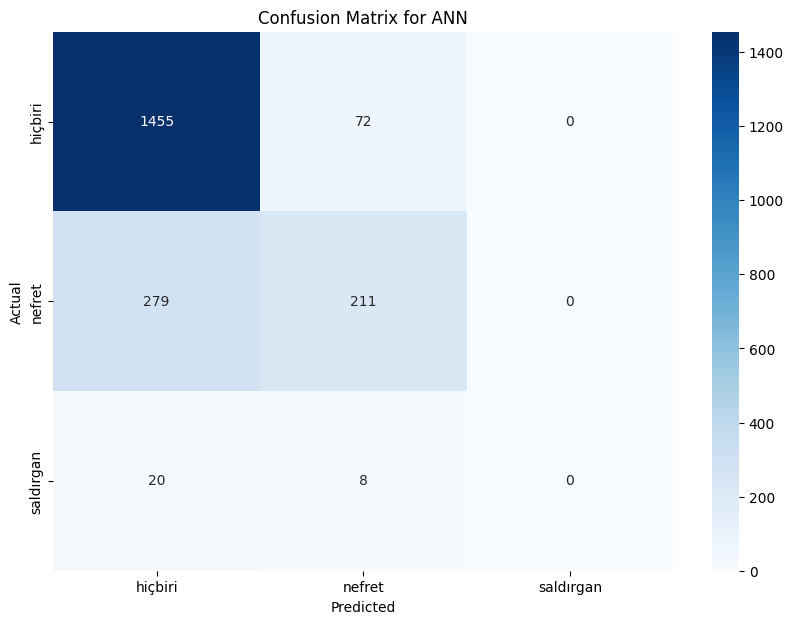

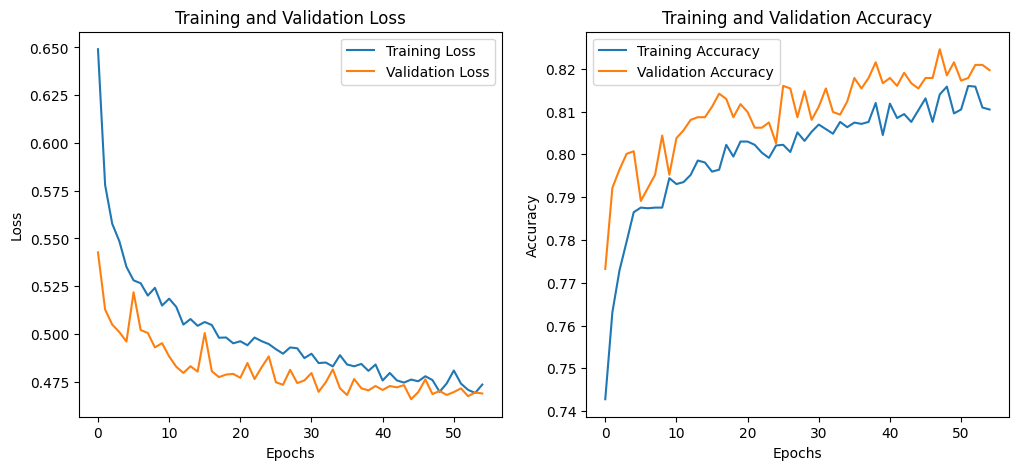


Applying SMOTE for oversampling...



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, pref

Epoch 1/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4460 - loss: 1.0284 - val_accuracy: 0.0000e+00 - val_loss: 1.4479
Epoch 2/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5698 - loss: 0.9102 - val_accuracy: 0.0207 - val_loss: 1.4714
Epoch 3/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5709 - loss: 0.8992 - val_accuracy: 0.0985 - val_loss: 1.3687
Epoch 4/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5963 - loss: 0.8747 - val_accuracy: 0.0603 - val_loss: 1.4081
Epoch 5/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5981 - loss: 0.8592 - val_accuracy: 0.3156 - val_loss: 1.2229
Epoch 6/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6056 - loss: 0.8375 - val_accuracy: 0.1501 - val_loss: 1.4117
Epoch 7/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6062 - loss: 0.8367 - val_accuracy: 0.3145 - val_loss: 1.2369
Epoch 8/50
465/465 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6190 - loss: 0.8295 - val_accuracy

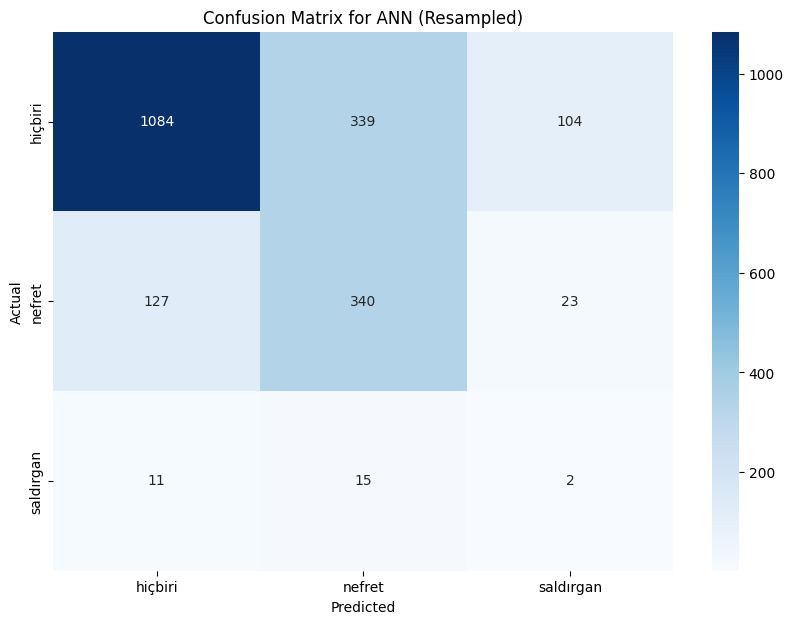

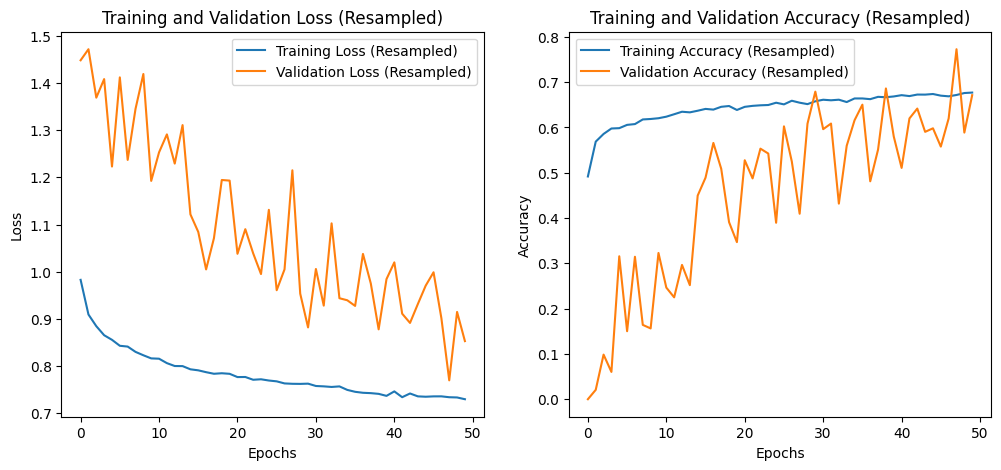

In [ ]:
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import numpy as np
from imblearn.combine import SMOTEENN
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
# Generate detailed report for ANN
print("\nClassification Report for ANN:\n")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix for ANN
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for ANN')
plt.show()

# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Resampling with SMOTE
print("\nApplying SMOTE for oversampling...\n")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Retrain ANN with resampled data
ann_model_resampled = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),

    Dropout(0.7),
    Dense(128, activation='relu'),

    Dropout(0.7),
    Dense(len(label_encoder.classes_), activation='softmax')
])
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
ann_model_resampled.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_resampled = ann_model_resampled.fit(X_resampled, y_resampled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
y_pred_resampled = ann_model_resampled.predict(X_test)
y_pred_classes_resampled = y_pred_resampled.argmax(axis=1)

# Evaluate ANN with resampled data
ann_accuracy_resampled = accuracy_score(y_test, y_pred_classes_resampled)
ann_precision_resampled = precision_score(y_test, y_pred_classes_resampled, average='weighted')
ann_recall_resampled = recall_score(y_test, y_pred_classes_resampled, average='weighted')
ann_f1_resampled = f1_score(y_test, y_pred_classes_resampled, average='weighted')

# Add resampled results to the results DataFrame
results['ANN (Resampled)'] = (ann_accuracy_resampled, ann_precision_resampled, ann_recall_resampled, ann_f1_resampled)
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-Score']).T

# Display updated results
print("\nUpdated Results with Resampling:\n")
print(results_df)

# Generate detailed report for ANN (Resampled)
print("\nClassification Report for ANN (Resampled):\n")
print(classification_report(y_test, y_pred_classes_resampled, target_names=label_encoder.classes_))

# Confusion Matrix for ANN (Resampled)
conf_matrix_resampled = confusion_matrix(y_test, y_pred_classes_resampled)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_resampled, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for ANN (Resampled)')
plt.show()

# Plot training and validation loss/accuracy for resampled data
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_resampled.history['loss'], label='Training Loss (Resampled)')
plt.plot(history_resampled.history['val_loss'], label='Validation Loss (Resampled)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Resampled)')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history_resampled.history['accuracy'], label='Training Accuracy (Resampled)')
plt.plot(history_resampled.history['val_accuracy'], label='Validation Accuracy (Resampled)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Resampled)')
plt.legend()

plt.show()



Applying SMOTE for oversampling and cleaning...

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validatio

233/233 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5071 - loss: 0.9849 - val_accuracy: 0.0043 - val_loss: 1.4566
Epoch 2/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5887 - loss: 0.8861 - val_accuracy: 0.0880 - val_loss: 1.4747
Epoch 3/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6143 - loss: 0.8460 - val_accuracy: 0.2927 - val_loss: 1.2855
Epoch 4/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6228 - loss: 0.8295 - val_accuracy: 0.2755 - val_loss: 1.2742
Epoch 5/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6288 - loss: 0.8076 - val_accuracy: 0.5313 - val_loss: 1.0248
Epoch 6/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6465 - loss: 0.7908 - val_accuracy: 0.4197 - val_loss: 1.2213
Epoch 7/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6465 - loss: 0.7761 - val_accuracy: 0.4065 - val_loss: 1.2332
Epoch 8/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6558 - loss: 0.7615 - val_accuracy: 0.3253 - val_

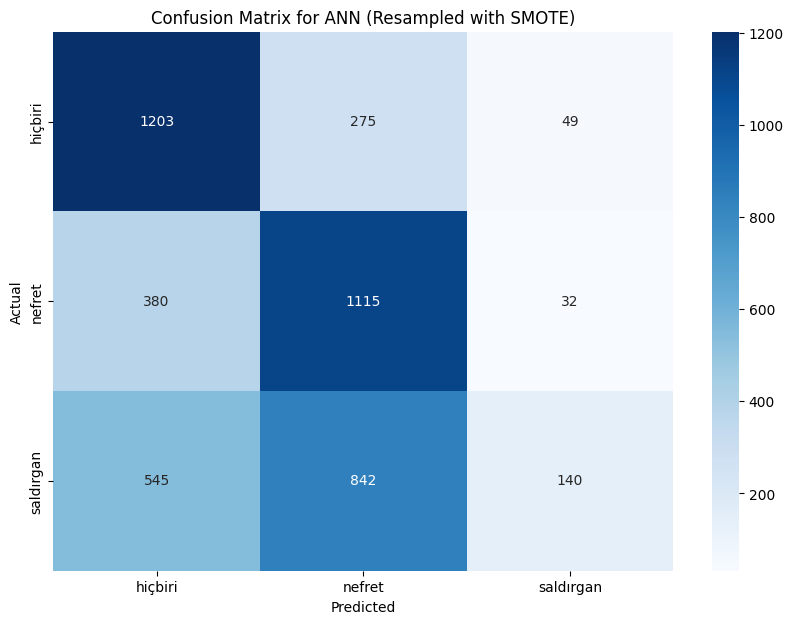

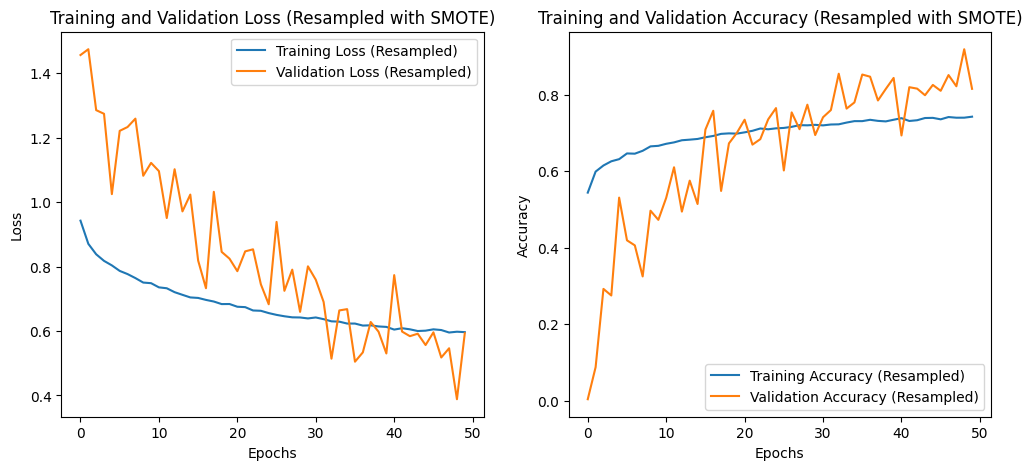

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTETomek uygulama
print("\nApplying SMOTE for oversampling and cleaning...\n")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

# Retrain ANN with resampled data
ann_model_resampled = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])
ann_model_resampled.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_resampled = ann_model_resampled.fit(X_resampled, y_resampled, epochs=50, batch_size=64, validation_split=0.2, verbose=1)

y_pred_resampled = ann_model_resampled.predict(X_test_resampled)
y_pred_classes_resampled = y_pred_resampled.argmax(axis=1)

# Evaluate ANN with resampled data
ann_accuracy_resampled = accuracy_score(y_test_resampled, y_pred_classes_resampled)
ann_precision_resampled = precision_score(y_test_resampled, y_pred_classes_resampled, average='weighted')
ann_recall_resampled = recall_score(y_test_resampled, y_pred_classes_resampled, average='weighted')
ann_f1_resampled = f1_score(y_test_resampled, y_pred_classes_resampled, average='weighted')

# Add resampled results to the results DataFrame
results['ANN (Smote test and train)'] = (ann_accuracy_resampled, ann_precision_resampled, ann_recall_resampled, ann_f1_resampled)
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-Score']).T

# Display updated results
print("\nUpdated Results with Resampling (SMOTE):\n")
print(results_df)

# Generate detailed report for ANN (Resampled with SMOTETomek)
print("\nClassification Report for ANN (Resampled with SMOTE):\n")
print(classification_report(y_test_resampled, y_pred_classes_resampled, target_names=label_encoder.classes_))

# Confusion Matrix for ANN (Resampled with SMOTETomek)
conf_matrix_resampled = confusion_matrix(y_test_resampled, y_pred_classes_resampled)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_resampled, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for ANN (Resampled with SMOTE)')
plt.show()

# Plot training and validation loss/accuracy for resampled data
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_resampled.history['loss'], label='Training Loss (Resampled)')
plt.plot(history_resampled.history['val_loss'], label='Validation Loss (Resampled)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Resampled with SMOTE)')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history_resampled.history['accuracy'], label='Training Accuracy (Resampled)')
plt.plot(history_resampled.history['val_accuracy'], label='Validation Accuracy (Resampled)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Resampled with SMOTE)')
plt.legend()

plt.show()
